<a href="https://colab.research.google.com/github/DGuilherme/PMTese/blob/main/Turbofan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
#import

# Install any missing libraries
!pip install tensorflow

# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam


# Data load

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

column_names = ['id', 'cycle', 'setting1', 'setting2', 'setting3'] + [f'sensor{i}' for i in range(1, 22)]


Mounted at /content/drive


## Load FD001


In [ ]:
# Load the dataset
# /content/drive/MyDrive/Python/predictive-maintenance-main/datasets/cmapss/train_FD001.txt
train_data = pd.read_csv('/content/drive/MyDrive/Python/predictive-maintenance-main/datasets/cmapss/train_FD001.txt/train_FD001.txt', delim_whitespace=True, header=None)
test_data = pd.read_csv('/content/drive/MyDrive/Python/predictive-maintenance-main/datasets/cmapss/test_FD001.txt/test_FD001.txt', delim_whitespace=True, header=None)
rul_data = pd.read_csv('/content/drive/MyDrive/Python/predictive-maintenance-main/datasets/cmapss/RUL_FD001.txt/RUL_FD001.txt', delim_whitespace=True, header=None)


<ipython-input-3-ca168e5c3bfe>:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  train_data = pd.read_csv('/content/drive/MyDrive/Python/predictive-maintenance-main/datasets/cmapss/train_FD001.txt/train_FD001.txt', delim_whitespace=True, header=None)
<ipython-input-3-ca168e5c3bfe>:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  test_data = pd.read_csv('/content/drive/MyDrive/Python/predictive-maintenance-main/datasets/cmapss/test_FD001.txt/test_FD001.txt', delim_whitespace=True, header=None)
<ipython-input-3-ca168e5c3bfe>:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  rul_data = pd.read_csv('/content/drive/MyDrive/Python/predictive-maintenance-main/datasets/cmapss/RUL_FD001.txt/RUL_FD001.txt', d

# Basic Data Info

In [ ]:
train_data.columns = column_names
test_data.columns = column_names
rul_data.columns = ['RUL']

print('---------------------Train Data---------------------')
print(train_data.head())
print('---------------------Test Data----------------------')
print(test_data.head())
print('----------------------RUL Data----------------------')
print(rul_data.head())

---------------------Train Data---------------------
   id  cycle  setting1  setting2  setting3  sensor1  sensor2  sensor3  \
0   1      1   -0.0007   -0.0004     100.0   518.67   641.82  1589.70   
1   1      2    0.0019   -0.0003     100.0   518.67   642.15  1591.82   
2   1      3   -0.0043    0.0003     100.0   518.67   642.35  1587.99   
3   1      4    0.0007    0.0000     100.0   518.67   642.35  1582.79   
4   1      5   -0.0019   -0.0002     100.0   518.67   642.37  1582.85   

   sensor4  sensor5  ...  sensor12  sensor13  sensor14  sensor15  sensor16  \
0  1400.60    14.62  ...    521.66   2388.02   8138.62    8.4195      0.03   
1  1403.14    14.62  ...    522.28   2388.07   8131.49    8.4318      0.03   
2  1404.20    14.62  ...    522.42   2388.03   8133.23    8.4178      0.03   
3  1401.87    14.62  ...    522.86   2388.08   8133.83    8.3682      0.03   
4  1406.22    14.62  ...    522.19   2388.04   8133.80    8.4294      0.03   

   sensor17  sensor18  sensor19  sensor

In [ ]:
# Check the shape of the data
print(f"Training Data Shape: {train_data.shape}")
print(f"Test Data Shape: {test_data.shape}")
print(f"RUL Data Shape: {rul_data.shape}")

# Check for missing values
print('---------------------Train Data---------------------')
print(train_data.isnull().sum())
print('---------------------Test Data----------------------')
print(test_data.isnull().sum())
print('----------------------RUL Data----------------------')
print(rul_data.isnull().sum())

Training Data Shape: (20631, 26)
Test Data Shape: (13096, 26)
RUL Data Shape: (100, 1)
---------------------Train Data---------------------
id          0
cycle       0
setting1    0
setting2    0
setting3    0
sensor1     0
sensor2     0
sensor3     0
sensor4     0
sensor5     0
sensor6     0
sensor7     0
sensor8     0
sensor9     0
sensor10    0
sensor11    0
sensor12    0
sensor13    0
sensor14    0
sensor15    0
sensor16    0
sensor17    0
sensor18    0
sensor19    0
sensor20    0
sensor21    0
dtype: int64
---------------------Test Data----------------------
id          0
cycle       0
setting1    0
setting2    0
setting3    0
sensor1     0
sensor2     0
sensor3     0
sensor4     0
sensor5     0
sensor6     0
sensor7     0
sensor8     0
sensor9     0
sensor10    0
sensor11    0
sensor12    0
sensor13    0
sensor14    0
sensor15    0
sensor16    0
sensor17    0
sensor18    0
sensor19    0
sensor20    0
sensor21    0
dtype: int64
----------------------RUL Data----------------------


In [ ]:
print(train_data.describe())


                 id         cycle      setting1      setting2  setting3  \
count  20631.000000  20631.000000  20631.000000  20631.000000   20631.0   
mean      51.506568    108.807862     -0.000009      0.000002     100.0   
std       29.227633     68.880990      0.002187      0.000293       0.0   
min        1.000000      1.000000     -0.008700     -0.000600     100.0   
25%       26.000000     52.000000     -0.001500     -0.000200     100.0   
50%       52.000000    104.000000      0.000000      0.000000     100.0   
75%       77.000000    156.000000      0.001500      0.000300     100.0   
max      100.000000    362.000000      0.008700      0.000600     100.0   

            sensor1       sensor2       sensor3       sensor4       sensor5  \
count  2.063100e+04  20631.000000  20631.000000  20631.000000  2.063100e+04   
mean   5.186700e+02    642.680934   1590.523119   1408.933782  1.462000e+01   
std    6.537152e-11      0.500053      6.131150      9.000605  3.394700e-12   
min    5

# Data Visualization

## Cycle Distribution
Quantos motores atingiram determinado numero de ciclos.


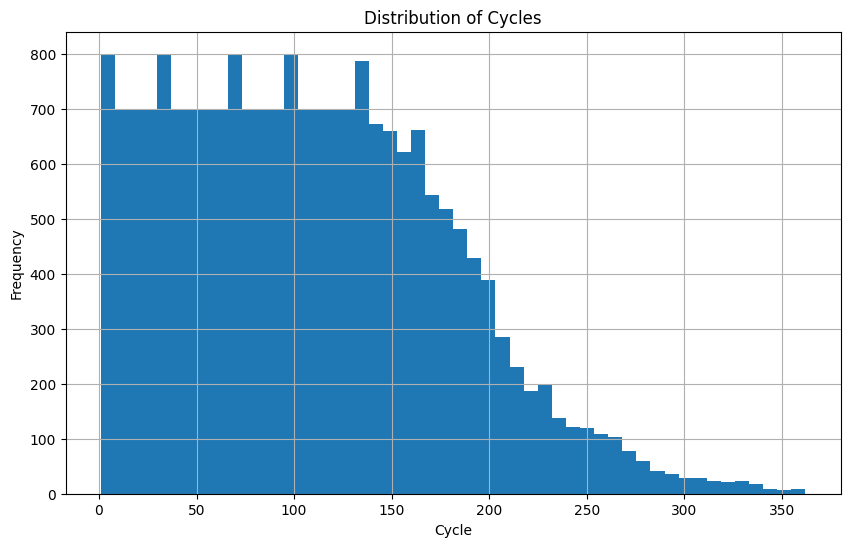

In [ ]:
plt.figure(figsize=(10, 6))
train_data['cycle'].hist(bins=50)
plt.xlabel('Cycle')
plt.ylabel('Frequency')
plt.title('Distribution of Cycles')
plt.show()


## Sensor info

Sensores 1,5,6,10,16,18,19 talvez nao sejam importantes.


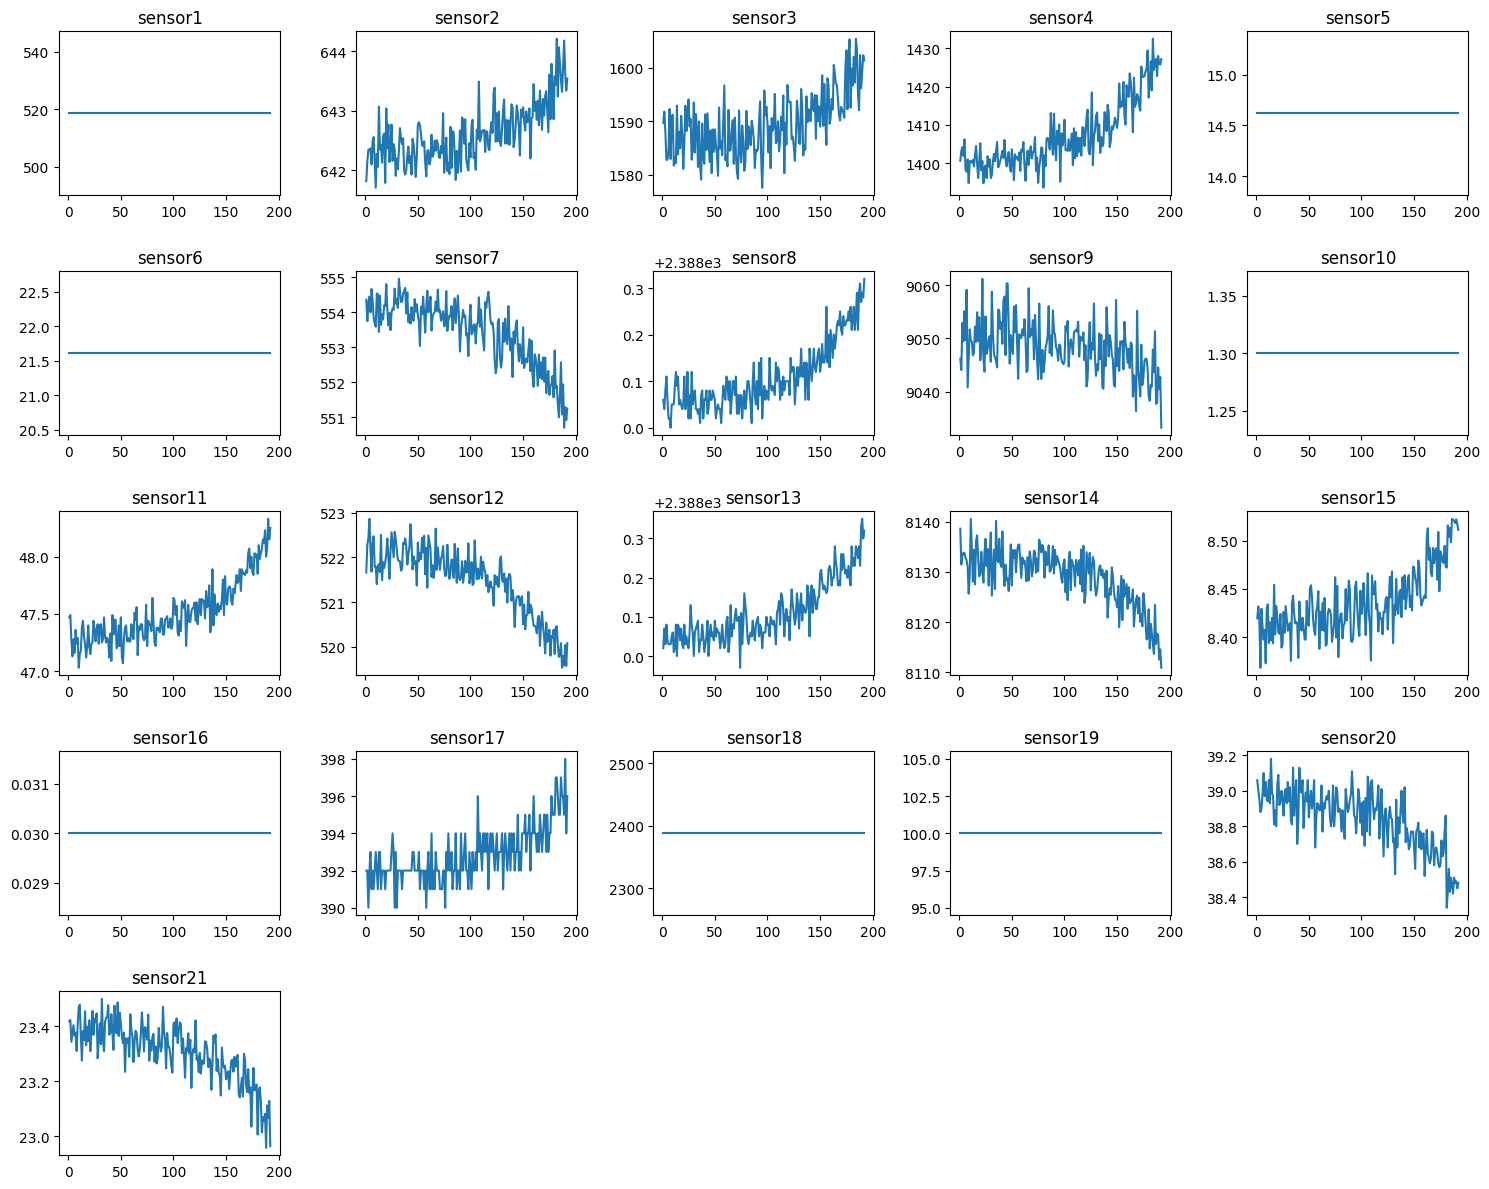

In [ ]:
engine_id = 1
engine_data = train_data[train_data['id'] == engine_id]

plt.figure(figsize=(15, 12))
for i in range(5, train_data.shape[1]):
    plt.subplot(5, 5, i-4)
    plt.plot(engine_data['cycle'], engine_data.iloc[:, i])
    plt.title(train_data.columns[i])
plt.tight_layout()
plt.show()


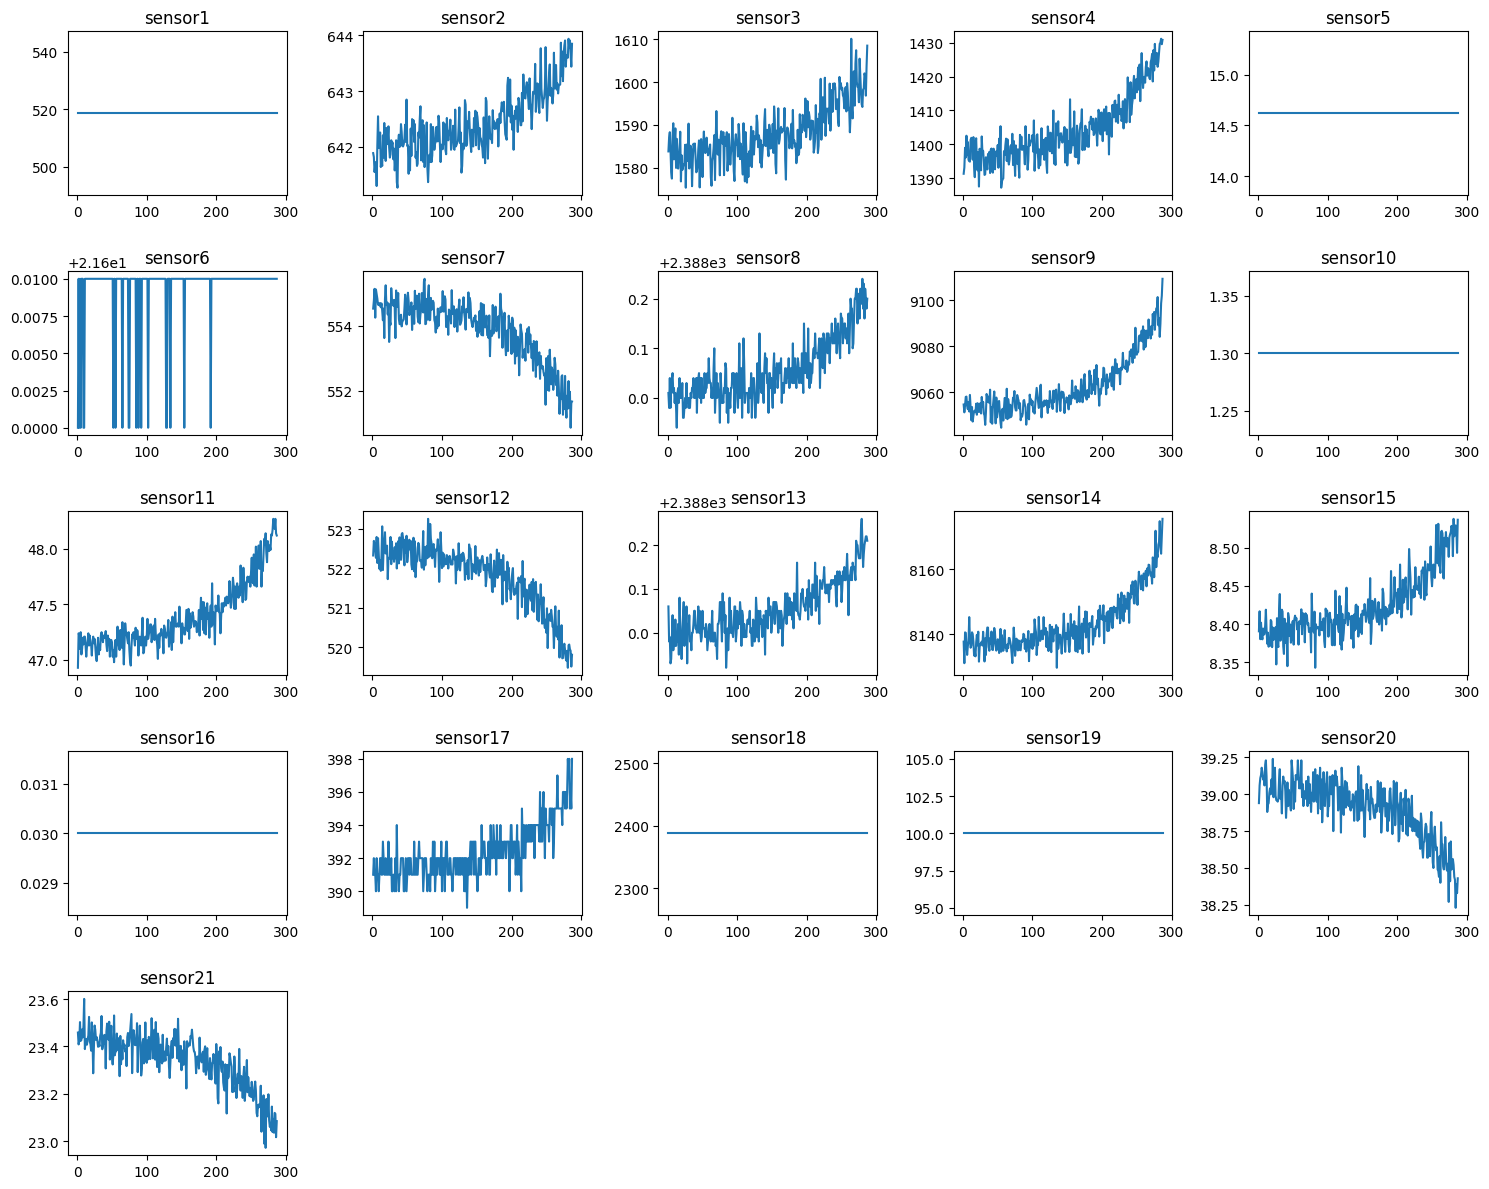

In [ ]:
engine_id = 2
engine_data = train_data[train_data['id'] == engine_id]

plt.figure(figsize=(15, 12))
for i in range(5, train_data.shape[1]):
    plt.subplot(5, 5, i-4)
    plt.plot(engine_data['cycle'], engine_data.iloc[:, i])
    plt.title(train_data.columns[i])
plt.tight_layout()
plt.show()

## Operational Settings
Ao longo do tempo as settings sao constantes.

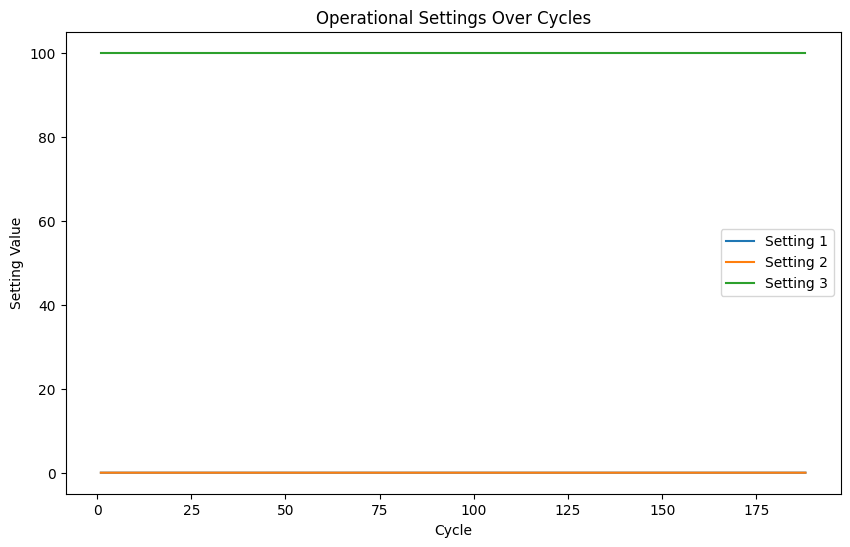

In [ ]:
engine_id = 6
engine_data = train_data[train_data['id'] == engine_id]

plt.figure(figsize=(10, 6))
plt.plot(engine_data['cycle'], engine_data['setting1'], label='Setting 1')
plt.plot(engine_data['cycle'], engine_data['setting2'], label='Setting 2')
plt.plot(engine_data['cycle'], engine_data['setting3'], label='Setting 3')
plt.xlabel('Cycle')
plt.ylabel('Setting Value')
plt.title('Operational Settings Over Cycles')
plt.legend()
plt.show()


## Heatmap
Correlaçao entre as diferentes features.


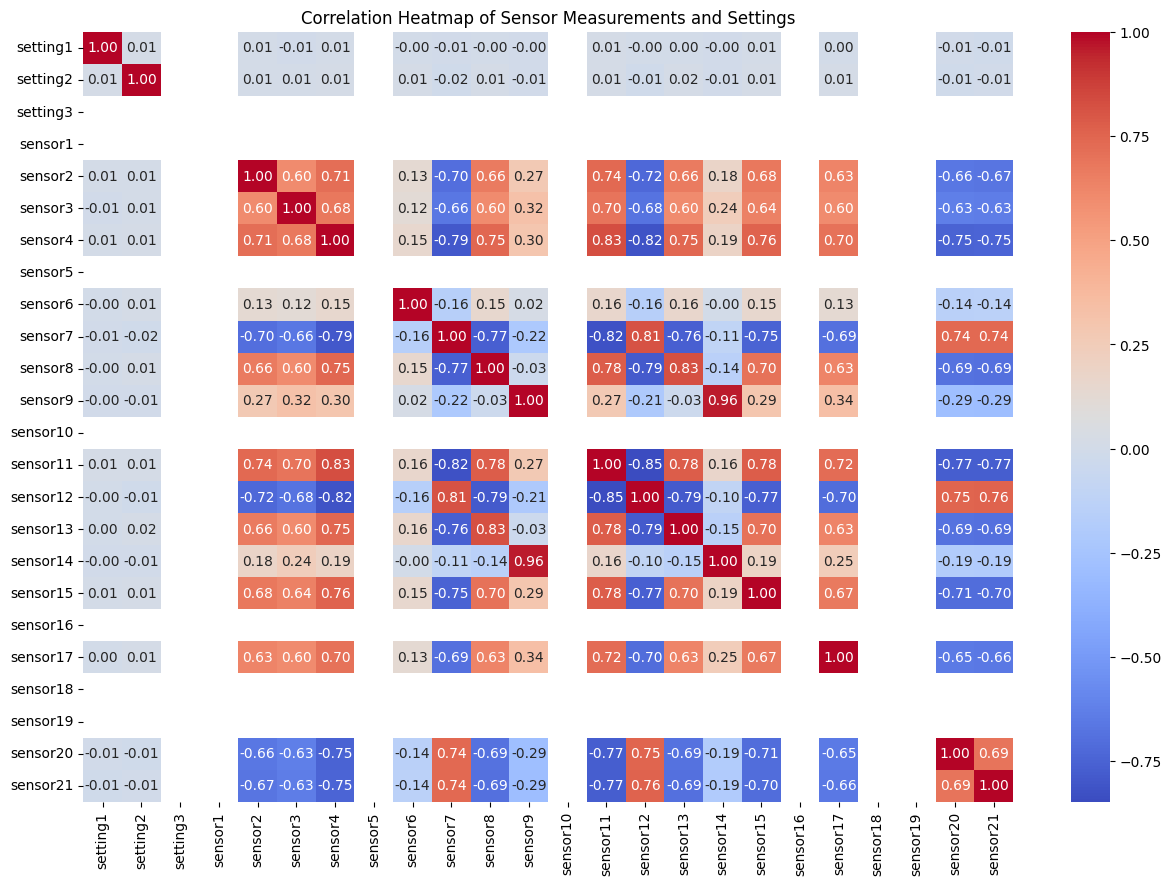

In [ ]:
plt.figure(figsize=(15, 10))
sns.heatmap(train_data.iloc[:, 2:].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap of Sensor Measurements and Settings')
plt.show()


## RUL Distribution
Quantos motores conseguiram atingir determinado valor de RUL.

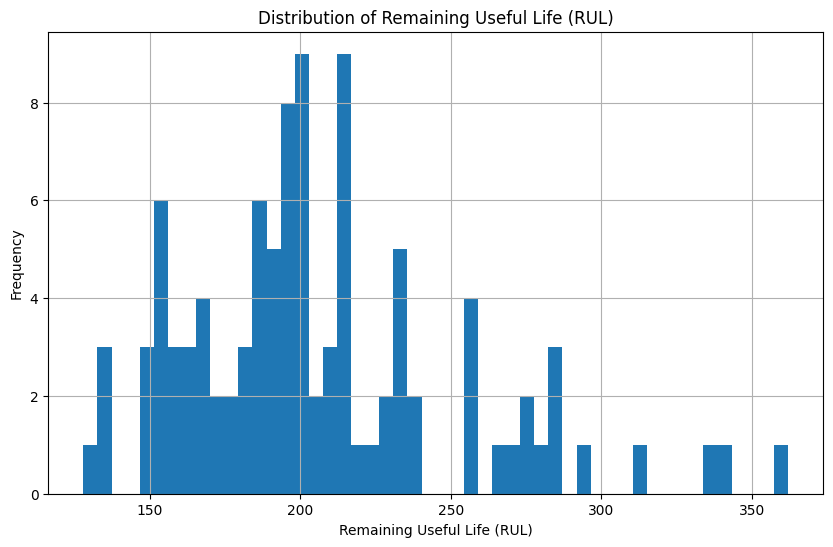

In [ ]:
# Calculate RUL for the training data
train_rul = train_data.groupby('id')['cycle'].max().reset_index()
train_rul.columns = ['id', 'max_cycle']
train_rul['RUL'] = train_rul['max_cycle']

plt.figure(figsize=(10, 6))
train_rul['RUL'].hist(bins=50)
plt.xlabel('Remaining Useful Life (RUL)')
plt.ylabel('Frequency')
plt.title('Distribution of Remaining Useful Life (RUL)')
plt.show()


# Data Preprocessing
Temos duas abordagens, ou usamos o RUL dataset ou calculamos nos mesmos.


## RUL calculation

In [ ]:
# Calculate RUL for training data
train_data['max_cycle'] = train_data.groupby('id')['cycle'].transform('max')
train_data['RUL'] = train_data['max_cycle'] - train_data['cycle']
train_data.drop('max_cycle', axis=1, inplace=True)

print('---------------------Train Data with RUL---------------------')
print(train_data.head())

---------------------Train Data with RUL---------------------
   id  cycle  setting1  setting2  setting3  sensor1  sensor2  sensor3  \
0   1      1   -0.0007   -0.0004     100.0   518.67   641.82  1589.70   
1   1      2    0.0019   -0.0003     100.0   518.67   642.15  1591.82   
2   1      3   -0.0043    0.0003     100.0   518.67   642.35  1587.99   
3   1      4    0.0007    0.0000     100.0   518.67   642.35  1582.79   
4   1      5   -0.0019   -0.0002     100.0   518.67   642.37  1582.85   

   sensor4  sensor5  ...  sensor13  sensor14  sensor15  sensor16  sensor17  \
0  1400.60    14.62  ...   2388.02   8138.62    8.4195      0.03       392   
1  1403.14    14.62  ...   2388.07   8131.49    8.4318      0.03       392   
2  1404.20    14.62  ...   2388.03   8133.23    8.4178      0.03       390   
3  1401.87    14.62  ...   2388.08   8133.83    8.3682      0.03       392   
4  1406.22    14.62  ...   2388.04   8133.80    8.4294      0.03       393   

   sensor18  sensor19  sensor2

In [ ]:
#Calculate RUL for test data
max_cycles_test = test_data.groupby('id')['cycle'].max().reset_index()
max_cycles_test.columns = ['id', 'max_cycle']
rul_data['id'] = rul_data.index + 1
rul_data = rul_data.merge(max_cycles_test, on='id', how='left')
rul_data['max_RUL'] = rul_data['RUL'] + rul_data['max_cycle']
rul_data.drop(['max_cycle', 'RUL'], axis=1, inplace=True)
test_data = test_data.merge(rul_data, on='id', how='left')
test_data['RUL'] = test_data['max_RUL'] - test_data['cycle']
test_data.drop('max_RUL', axis=1, inplace=True)

print('---------------------Test Data with RUL---------------------')
print(test_data.head())


# Ensure 'RUL' column exists in both train and test data
assert 'RUL' in train_data.columns, "RUL column missing in training data"
assert 'RUL' in test_data.columns, "RUL column missing in test data"


---------------------Test Data with RUL---------------------
   id  cycle  setting1  setting2  setting3  sensor1  sensor2  sensor3  \
0   1      1    0.0023    0.0003     100.0   518.67   643.02  1585.29   
1   1      2   -0.0027   -0.0003     100.0   518.67   641.71  1588.45   
2   1      3    0.0003    0.0001     100.0   518.67   642.46  1586.94   
3   1      4    0.0042    0.0000     100.0   518.67   642.44  1584.12   
4   1      5    0.0014    0.0000     100.0   518.67   642.51  1587.19   

   sensor4  sensor5  ...  sensor13  sensor14  sensor15  sensor16  sensor17  \
0  1398.21    14.62  ...   2388.03   8125.55    8.4052      0.03       392   
1  1395.42    14.62  ...   2388.06   8139.62    8.3803      0.03       393   
2  1401.34    14.62  ...   2388.03   8130.10    8.4441      0.03       393   
3  1406.42    14.62  ...   2388.05   8132.90    8.3917      0.03       391   
4  1401.92    14.62  ...   2388.03   8129.54    8.4031      0.03       390   

   sensor18  sensor19  sensor20

## Normalização

In [ ]:
# Select features to normalize
feature_cols = train_data.columns.difference(['id', 'cycle', 'RUL'])
scaler = MinMaxScaler()
train_data[feature_cols] = scaler.fit_transform(train_data[feature_cols])
test_data[feature_cols] = scaler.transform(test_data[feature_cols])


## LSTM application

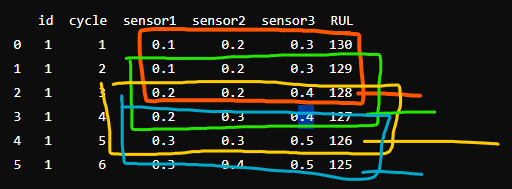

In [ ]:
def create_sequences(data, seq_length=50):
    sequences = []
    labels = []
    ids = data['id'].unique()

    for id in ids:
        id_data = data[data['id'] == id].reset_index(drop=True)
        num_cycles = len(id_data)

        if num_cycles < seq_length:
            continue

        for start in range(num_cycles - seq_length):
            seq = id_data.iloc[start:start+seq_length][feature_cols].values
            label = id_data.iloc[start+seq_length-1]['RUL']

            sequences.append(seq)
            labels.append(label)

    return np.array(sequences), np.array(labels)

# Create sequences for training and testing
seq_length = 50
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

print(f"Training Sequences Shape: {X_train.shape}")
print(f"Training Labels Shape: {y_train.shape}")
print(f"Test Sequences Shape: {X_test.shape}")
print(f"Test Labels Shape: {y_test.shape}")

print(f"NaNs in sequences: {np.isnan(X_train).sum()}")
print(f"NaNs in labels: {np.isnan(y_train).sum()}")


X_test, y_test = create_sequences(test_data, seq_length)
print(f"NaNs in sequences: {np.isnan(X_test).sum()}")
print(f"NaNs in labels: {np.isnan(y_test).sum()}")

Training Sequences Shape: (15631, 50, 24)
Training Labels Shape: (15631,)
Test Sequences Shape: (8162, 50, 24)
Test Labels Shape: (8162,)
NaNs in sequences: 0
NaNs in labels: 0
NaNs in sequences: 0
NaNs in labels: 0


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [ ]:


# Build the LSTM model
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(seq_length, len(feature_cols))),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 50, 100)             │          50,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          30,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 80,251 (313.48 KB)

 Trainable params: 80,251 (313.48 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 28s 116ms/step - loss: 9082.4316 - val_loss: 7623.3423
Epoch 2/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 24s 121ms/step - loss: 7139.0112 - val_loss: 6479.3247
Epoch 3/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 40s 116ms/step - loss: 6265.5801 - val_loss: 5595.6196
Epoch 4/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 40s 113ms/step - loss: 5336.6616 - val_loss: 4915.7471
Epoch 5/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 24s 122ms/step - loss: 4810.4521 - val_loss: 4402.1978
Epoch 6/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 43s 131ms/step - loss: 4448.4106 - val_loss: 4026.4397
Epoch 7/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 21s 109ms/step - loss: 3919.0935 - val_loss: 3758.2158
Epoch 8/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 41s 108ms/step - loss: 3634.5459 - val_loss: 3574.6763
Epoch 9/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 25s 125ms/step - loss: 3543.7341 - val_loss: 3453.1777
Epoch 10/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 41s 124ms/step - loss: 3380.2559 - val_loss: 3377.3594
Epoch 11/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 42s 129m

In [ ]:
# Predictions
y_pred = model.predict(X_test)


# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')


256/256 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step
RMSE: 31.49123685098126
MAE: 22.30921719933631


In [ ]:
 # Define LSTM Model
model2 = Sequential([
    LSTM(128, return_sequences=True, input_shape=(seq_length, len(feature_cols))),
    LSTM(64, return_sequences=False),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='linear')  # RUL prediction
])

model2.compile(optimizer='adam', loss='mse', metrics=['mae'])
model2.summary()

history = model2.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=50,
                    batch_size=64)


## test this
#early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

#history = model.fit(X_train, y_train,
                    #validation_data=(X_val, y_val),
                    #epochs=50,
                    #batch_size=64,
                    #callbacks=[early_stopping])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 50, 128)             │          78,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 129,857 (507.25 KB)

 Trainable params: 129,857 (507.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 39s 172ms/step - loss: 8155.7510 - mae: 71.6184 - val_loss: 3394.9224 - val_mae: 45.8104
Epoch 2/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 32s 163ms/step - loss: 3438.7783 - mae: 47.0291 - val_loss: 3283.2666 - val_mae: 45.7905
Epoch 3/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 43s 175ms/step - loss: 3423.8782 - mae: 46.9569 - val_loss: 3286.5703 - val_mae: 45.7538
Epoch 4/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 38s 161ms/step - loss: 3403.7727 - mae: 47.2111 - val_loss: 3284.5715 - val_mae: 45.7747
Epoch 5/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 41s 161ms/step - loss: 3408.1311 - mae: 47.1958 - val_loss: 3280.4600 - val_mae: 45.8437
Epoch 6/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 41s 160ms/step - loss: 3332.3589 - mae: 46.5907 - val_loss: 3290.9114 - val_mae: 45.7266
Epoch 7/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 41s 158ms/step - loss: 3430.6118 - mae: 47.0022 - val_loss: 3288.9302 - val_mae: 45.7374
Epoch 8/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 44s 175ms/step - loss: 3466.1838 - mae: 47.2976 - val_los

In [ ]:
# Predictions
y_pred2 = model2.predict(X_test)


# Calculate metrics
rmse2 = np.sqrt(mean_squared_error(y_test, y_pred))
mae2 = mean_absolute_error(y_test, y_pred2)

print(f'RMSE: {rmse2}')
print(f'MAE: {mae2}')


256/256 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step
RMSE: 31.49123685098126
MAE: 27.76935382235199
